# Learning How to Label SpO2 Low Alarms as Suppressible/Not-Suppressible 

The underlying idea of Smart Alarm 2.0 is to reduce the number of false SpO2 low alarms produced by pulse oximetry machines. We intend to use some machine learning techniques in order to make a "smart" alarm that can automatically suppress false alarms. A big challenge with ML is that large labeled datasets are scarce and expensive to produce. Hence, here we are using Snorkel's data programming paradigm to design a label model that can label with confidence a dataset of unlabeled SpO2 alarms as suppressible/not-suppressible.

To do this week:
- [ ] Take the maximum independent sets, for each set train a label model and let that model be a LF, re-run CDM on new LFs to determine the dependencies (Note: if it is too many LFs then randomly select the max amount able to)

In [1]:
from snorkel.labeling.apply.dask import PandasParallelLFApplier
from snorkel.labeling.model.label_model import LabelModel
from snorkel.labeling import labeling_function, LFAnalysis
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix
from read_chop_data import read_alarms, read_vitals
from compute_mp import apply_compute_mp
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from time import time
import pandas as pd
import numpy as np

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.min_rows", None)

## Loading Data
- **alarms_df**: data for 3,265 SpO2 low alarms from CHOP data
- **vitals_df**: data for vital signs of 100 patients related to the alarms data

(Note: "chop_spo2alarms_df.pkl" and "chop_vitals_df.pkl" can be obtained by running functions defined in /smart-alarm-learning-labels/read_chop_data.py. For "chop_vitals_with_mp_df.pkl", load "chop_vitals_df.pkl" and see [matrix profile](#matrix_profile) cell.)

In [3]:
# For clarity, defining constants for to represent class labels

ABSTAIN = -1
NOT_SUPPRESSIBLE = 0
SUPPRESSIBLE = 1

In [4]:
# Setting global constant to represent sampling rate of 1 data point per 5 seconds in CHOP data

INTERVAL = 5

In [5]:
from os import path

# Read in alarms data
if path.exists("chop_spo2alarms_df.pkl"):
    alarms_df = pd.read_pickle("chop_spo2alarms_df.pkl")
else:
    alarms_df = read_alarms(save=True)

# Read in vitals data
if path.exists("chop_vitals_with_mp_df.pkl"):
    vitals_df = pd.read_pickle("chop_vitals_with_mp_df.pkl")    # CHOP vitals with precomputed matrix profiles
elif path.exists("chop_vitals_df.pkl"):
    temp_vitals_df = pd.read_pickle("chop_vitals_df.pkl")
    vitals_df = apply_compute_mp(vitals_wo_mp_df, ["SPO2-%","HR","RESP"], INTERVAL, save=True, filename="trial.pkl")
else:
    temp_vitals_df = read_vitals(verbose=True, save=True)
    vitals_df = apply_compute_mp(temp_vitals_df, ["SPO2-%","HR","RESP"], INTERVAL, save=True, filename="trial.pkl")

In [6]:
# Set age factors for labeling functions

age_factors_df = pd.DataFrame({'pt_age_group':[1,2,3,4], 
                                'pt_age_group_L':['< 1 month','1-< 2 month','2-< 6 month','6 months and older'], 
                                'hr_age_factor':[3.833, 3.766, 3.733, 3.533], 
                                'rr_age_factor':[0.933, 0.9, 0.866, 0.8]}, 
                                index=[1,2,3,4])

## Define Labeling Functions

In [7]:
def get_vitals(pt_id, v_sign, t_start=None, t_end=None):
    """
    Get timeseries of a specific vital sign for a given patient
    
    Args:
        pt_id - integer id of patient
        v_sign - string vital sign name
        t_start - start timestamp 
        t_end - end timestamp
        
    Return:
        timeseries array of vital sign for patient
    """
    return vitals_df.loc[(pt_id, ), v_sign][t_start:t_end]


@labeling_function()
def lf_long_alarm_60s(x):
    """
    If the alarm duration is at least 60 seconds then the alarm is not suppressible, 
    otherwise abstain 
    """
    return NOT_SUPPRESSIBLE if x.duration >= 60 else ABSTAIN


@labeling_function()
def lf_long_alarm_65s(x):
    """
    If the alarm duration is at least 65 seconds then the alarm is not suppressible, 
    otherwise abstain 
    """
    return NOT_SUPPRESSIBLE if x.duration >= 65 else ABSTAIN


@labeling_function()
def lf_long_alarm_70s(x):
    """
    If the alarm duration is at least 70 seconds then the alarm is not suppressible, 
    otherwise abstain 
    """
    return NOT_SUPPRESSIBLE if x.duration >= 70 else ABSTAIN


@labeling_function()
def lf_spo2_below85_over120s(x):
    """
    If SpO2 level stays within range (80,85] for longer than 120 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=121)))
    return NOT_SUPPRESSIBLE if np.all( (80 < spo2) & (spo2 <= 85) ) else ABSTAIN


@labeling_function()
def lf_spo2_below80_over100s(x):
    """
    If SpO2 level stays within range (70,80] for longer than 100 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=101)))
    return NOT_SUPPRESSIBLE if np.all( (70 < spo2) & (spo2 <= 80) ) else ABSTAIN


@labeling_function()
def lf_spo2_below70_over90s(x):
    """
    If SpO2 level stays within range (60,70] for longer than 90 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=91)))
    return NOT_SUPPRESSIBLE if np.all( (60 < spo2) & (spo2 <= 70) ) else ABSTAIN


@labeling_function()
def lf_spo2_below60_over60s(x):
    """
    If SpO2 level stays within range (50,60] for longer than 60 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=61)))
    return NOT_SUPPRESSIBLE if np.all( (50 < spo2) & (spo2 <= 60) ) else ABSTAIN


@labeling_function()
def lf_spo2_below50_over30s(x):
    """
    If SpO2 level stays within range (0,50] for longer than 30 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=31)))
    return NOT_SUPPRESSIBLE if np.all( spo2 <= 50 ) else ABSTAIN
    

@labeling_function()
def lf_hr_below50_over120s(x):
    """
    If HR below 50 * age factor for over 120 seconds since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    hr = get_vitals(x.pt_id, "HR", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=121)))
    age_factor = age_factors_df.loc[x.pt_age_group, "hr_age_factor"]
    return NOT_SUPPRESSIBLE if np.all( (40*age_factor < hr) & (hr <= 50*age_factor) ) else ABSTAIN
    
    
@labeling_function()
def lf_hr_below40_over60s(x):
    """
    If HR below 40 * age factor for over 60 seconds since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    hr = get_vitals(x.pt_id, "HR", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=61)))
    age_factor = age_factors_df.loc[x.pt_age_group, "hr_age_factor"]
    return NOT_SUPPRESSIBLE if np.all( (30*age_factor < hr) & (hr <= 40*age_factor) ) else ABSTAIN


@labeling_function()
def lf_hr_below30(x):
    """
    If HR below 30 * age factor for any duration since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    hr = get_vitals(x.pt_id, "HR", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=int(x.duration))))
    age_factor = age_factors_df.loc[x.pt_age_group, "hr_age_factor"]
    return NOT_SUPPRESSIBLE if np.all( hr <= 30*age_factor ) else ABSTAIN


@labeling_function()
def lf_rr_below50_over120s(x):
    """
    If RR below 50 * age factor for over 120 seconds since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    rr = get_vitals(x.pt_id, "RESP", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=121)))
    age_factor = age_factors_df.loc[x.pt_age_group, "rr_age_factor"]
    return NOT_SUPPRESSIBLE if np.all( (40*age_factor < rr) & (rr <= 50*age_factor) ) else ABSTAIN


@labeling_function()
def lf_rr_below40_over60s(x):
    """
    If RR below 40 * age factor for over 60 seconds since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    rr = get_vitals(x.pt_id, "RESP", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=61)))
    age_factor = age_factors_df.loc[x.pt_age_group, "rr_age_factor"]
    return NOT_SUPPRESSIBLE if np.all( (30*age_factor < rr) & (rr <= 40*age_factor) ) else ABSTAIN


@labeling_function()
def lf_rr_below30(x):
    """
    If RR below 30 * age factor for any duration since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    rr = get_vitals(x.pt_id, "RESP", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=int(x.duration))))
    age_factor = age_factors_df.loc[x.pt_age_group, "rr_age_factor"]
    return NOT_SUPPRESSIBLE if np.all( rr <= 30*age_factor ) else ABSTAIN
    
    
def repeat_alarms(x, t):
    """
    If there exists other SpO2 alarms 't' minutes prior to the current alarm's start time and/or
    if there exists other SpO2 alarms 't' minutes after the current alarm's end time then
    the alarm is not suppressible, otherwise abstain

    Args:
        x - alarm instance
        t - timespan to consider (in seconds)
    """
    prior_alarms = alarms_df[ (alarms_df["pt_id"] == x.pt_id) & \
                                (x.alarm_datetime - timedelta(seconds=t) <= alarms_df["alarm_datetime"]) & \
                                (alarms_df["alarm_datetime"] < x.alarm_datetime) ]

    subsq_alarms = alarms_df[ (alarms_df["pt_id"] == x.pt_id) & \
                                (x.alarm_datetime + timedelta(seconds=int(x.duration)) <= alarms_df["alarm_datetime"]) & \
                                (alarms_df["alarm_datetime"] <= x.alarm_datetime + timedelta(seconds=int(x.duration + t))) ]
    
    count = prior_alarms.shape[0] + subsq_alarms.shape[0]
    
    return NOT_SUPPRESSIBLE if count > 0 else ABSTAIN


@labeling_function()
def lf_repeat_alarms_15s(x):
    """
    If there exists other alarms within 15 seconds of the current alarm then the alarm is
    not suppressible, otherwise abstain
    """
    return repeat_alarms(x, 15) 


@labeling_function()
def lf_repeat_alarms_30s(x):
    """
    If there exists other alarms within 30 seconds of the current alarm then the alarm is
    not suppressible, otherwise abstain
    """
    return repeat_alarms(x, 30) 


@labeling_function()
def lf_repeat_alarms_60s(x):
    """
    If there exists other alarms within 60 seconds of the current alarm then the alarm is
    not suppressible, otherwise abstain
    """
    return repeat_alarms(x, 60)


@labeling_function()
def lf_gradual_recovery(x):
    """
    If SpO2 increases at 5-10% per minute after the alarm then the alarm is not suppressible,
    otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%")
    return ABSTAIN


@labeling_function()
def lf_short_alarm_15s(x):
    """
    If the SpO2-Low alarm duration is at most 15 seconds then the alarm is suppressible, 
    otherwise abstain 
    """
    return SUPPRESSIBLE if x.duration <= 15 else ABSTAIN


@labeling_function()
def lf_short_alarm_10s(x):
    """
    If the SpO2-Low alarm duration is at most 10 seconds then the alarm is suppressible, 
    otherwise abstain 
    """
    return SUPPRESSIBLE if x.duration <= 10 else ABSTAIN


@labeling_function()
def lf_short_alarm_5s(x):
    """
    If the SpO2-Low alarm duration is at most 5 seconds then the alarm is suppressible, 
    otherwise abstain 
    """
    return SUPPRESSIBLE if x.duration <= 5 else ABSTAIN


def max_recovery(data):
    """
    Determine the maximum recovery between two consecutive data points in given data
    
    Args:
        data - array of numeric measurements
        
    Return:
        float - maximum recovery
    """
    r = []
    
    for i in range(len(data)):
        for j in range(i+1, len(data)):
            r.append(data[j] - data[i])
            
    return max(r)


@labeling_function()
def lf_immediate_recovery_10s(x):
    """
    If SpO2 level increases/recovers by more than 20 percentage points within 
    10 seconds of alarm start then the alarm is suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=10)))
    if len(spo2) < 2:
        return ABSTAIN
    return SUPPRESSIBLE if max_recovery(spo2) > 20 else ABSTAIN


@labeling_function()
def lf_immediate_recovery_15s(x):
    """
    If SpO2 level increases/recovers by more than 30 percentage points within 
    15 seconds of alarm start then the alarm is suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=15)))
    if len(spo2) < 2:
        return ABSTAIN
    return SUPPRESSIBLE if max_recovery(spo2) > 30 else ABSTAIN


@labeling_function()
def lf_hr_tech_err_20(x):
    """
    If the difference between the SpO2 HR and ECG HR is larger than 20 percentage points 
    at time of alarm then suppressible, otherwise abstain
    """
    spo2_hr = get_vitals(x.pt_id, "SPO2-R")
    ecg_hr = get_vitals(x.pt_id, "HR")
    return SUPPRESSIBLE if abs(spo2_hr[x.alarm_datetime] - ecg_hr[x.alarm_datetime]) > 20 else ABSTAIN


@labeling_function()
def lf_hr_tech_err_30(x):
    """
    If the difference between the SpO2 HR and ECG HR is larger than 30 percentage points 
    at time of alarm then suppressible, otherwise abstain
    """
    spo2_hr = get_vitals(x.pt_id, "SPO2-R")
    ecg_hr = get_vitals(x.pt_id, "HR")
    return SUPPRESSIBLE if abs(spo2_hr[x.alarm_datetime] - ecg_hr[x.alarm_datetime]) > 30 else ABSTAIN


@labeling_function()
def lf_outlier_spo2_120(x):
    """
    If there exists an outlier (spike in matrix profile larger than 8.4) in the 
    120 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP120",
                      t_start=(x.alarm_datetime - timedelta(seconds=60)),
                      t_end=(x.alarm_datetime + timedelta(seconds=60)) )
    return SUPPRESSIBLE if np.any( spo2 > 8.4 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_110(x):
    """
    If there exists an outlier (spike in matrix profile larger than 7.8) in the 
    110 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP110",
                      t_start=(x.alarm_datetime - timedelta(seconds=55)),
                      t_end=(x.alarm_datetime + timedelta(seconds=55)) )
    return SUPPRESSIBLE if np.any( spo2 > 7.8 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_100(x):
    """
    If there exists an outlier (spike in matrix profile larger than 7.2) in the 
    100 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP100",
                      t_start=(x.alarm_datetime - timedelta(seconds=50)),
                      t_end=(x.alarm_datetime + timedelta(seconds=50)) )
    return SUPPRESSIBLE if np.any( spo2 > 7.2 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_90(x):
    """
    If there exists an outlier (spike in matrix profile larger than 6.6) in the 
    90 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP90",
                      t_start=(x.alarm_datetime - timedelta(seconds=45)),
                      t_end=(x.alarm_datetime + timedelta(seconds=45)) )
    return SUPPRESSIBLE if np.any( spo2 > 6.6 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_80(x):
    """
    If there exists an outlier (spike in matrix profile larger than 6.0) in the 
    80 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP80",
                      t_start=(x.alarm_datetime - timedelta(seconds=40)),
                      t_end=(x.alarm_datetime + timedelta(seconds=40)) )
    return SUPPRESSIBLE if np.any( spo2 > 6.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_70(x):
    """
    If there exists an outlier (spike in matrix profile larger than 5.3) in the 
    70 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP70",
                      t_start=(x.alarm_datetime - timedelta(seconds=35)),
                      t_end=(x.alarm_datetime + timedelta(seconds=35)) )
    return SUPPRESSIBLE if np.any( spo2 > 5.3 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_60(x):
    """
    If there exists an outlier (spike in matrix profile larger than 4.6) in the 
    60 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP60",
                      t_start=(x.alarm_datetime - timedelta(seconds=30)),
                      t_end=(x.alarm_datetime + timedelta(seconds=30)) )
    return SUPPRESSIBLE if np.any( spo2 > 4.6 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_50(x):
    """
    If there exists an outlier (spike in matrix profile larger than 3.8) in the 
    50 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP50",
                      t_start=(x.alarm_datetime - timedelta(seconds=25)),
                      t_end=(x.alarm_datetime + timedelta(seconds=25)) )
    return SUPPRESSIBLE if np.any( spo2 > 3.8 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_40(x):
    """
    If there exists an outlier (spike in matrix profile larger than 2.9) in the 
    40 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP40",
                      t_start=(x.alarm_datetime - timedelta(seconds=20)),
                      t_end=(x.alarm_datetime + timedelta(seconds=20)) )
    return SUPPRESSIBLE if np.any( spo2 > 2.9 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_30(x):
    """
    If there exists an outlier (spike in matrix profile larger than 2.1) in the 
    30 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP30",
                      t_start=(x.alarm_datetime - timedelta(seconds=15)),
                      t_end=(x.alarm_datetime + timedelta(seconds=15)) )
    return SUPPRESSIBLE if np.any( spo2 > 2.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_20(x):
    """
    If there exists an outlier (spike in matrix profile larger than 1.0) in the 
    20 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP20",
                      t_start=(x.alarm_datetime - timedelta(seconds=10)),
                      t_end=(x.alarm_datetime + timedelta(seconds=10)) )
    return SUPPRESSIBLE if np.any( spo2 > 1.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_120(x):
    """
    If there exists at least one data point where the 120-second window heart rate matrix profile
    exceeds 9.0 within a 120-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP120",
                       t_start=(x.alarm_datetime - timedelta(seconds=60)),
                       t_end=(x.alarm_datetime + timedelta(seconds=60)) )
    return SUPPRESSIBLE if np.any( hr_mp > 9.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_110(x):
    """
    If there exists at least one data point where the 110-second window heart rate matrix profile
    exceeds 8.5 within a 110-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP110",
                       t_start=(x.alarm_datetime - timedelta(seconds=55)),
                       t_end=(x.alarm_datetime + timedelta(seconds=55)) )
    return SUPPRESSIBLE if np.any( hr_mp > 8.5 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_100(x):
    """
    If there exists at least one data point where the 100-second window heart rate matrix profile
    exceeds 7.8 within a 100-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP100",
                       t_start=(x.alarm_datetime - timedelta(seconds=50)),
                       t_end=(x.alarm_datetime + timedelta(seconds=50)) )
    return SUPPRESSIBLE if np.any( hr_mp > 7.8 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_90(x):
    """
    If there exists at least one data point where the 90-second window heart rate matrix profile
    exceeds 7.3 within a 90-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP90",
                       t_start=(x.alarm_datetime - timedelta(seconds=45)),
                       t_end=(x.alarm_datetime + timedelta(seconds=45)) )
    return SUPPRESSIBLE if np.any( hr_mp > 7.3 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_80(x):
    """
    If there exists at least one data point where the 80-second window heart rate matrix profile
    exceeds 6.7 within a 80-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP80",
                       t_start=(x.alarm_datetime - timedelta(seconds=40)),
                       t_end=(x.alarm_datetime + timedelta(seconds=40)) )
    return SUPPRESSIBLE if np.any( hr_mp > 6.7 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_70(x):
    """
    If there exists at least one data point where the 70-second window heart rate matrix profile
    exceeds 6.0 within a 70-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP70",
                       t_start=(x.alarm_datetime - timedelta(seconds=35)),
                       t_end=(x.alarm_datetime + timedelta(seconds=35)) )
    return SUPPRESSIBLE if np.any( hr_mp > 6.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_60(x):
    """
    If there exists at least one data point where the 60-second window heart rate matrix profile
    exceeds 5.4 within a 60-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP60",
                       t_start=(x.alarm_datetime - timedelta(seconds=30)),
                       t_end=(x.alarm_datetime + timedelta(seconds=30)) )
    return SUPPRESSIBLE if np.any( hr_mp > 5.4 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_50(x):
    """
    If there exists at least one data point where the 50-second window heart rate matrix profile
    exceeds 4.7 within a 50-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP50",
                       t_start=(x.alarm_datetime - timedelta(seconds=25)),
                       t_end=(x.alarm_datetime + timedelta(seconds=25)) )
    return SUPPRESSIBLE if np.any( hr_mp > 4.7 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_40(x):
    """
    If there exists at least one data point where the 40-second window heart rate matrix profile
    exceeds 3.9 within a 40-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP40",
                       t_start=(x.alarm_datetime - timedelta(seconds=20)),
                       t_end=(x.alarm_datetime + timedelta(seconds=20)) )
    return SUPPRESSIBLE if np.any( hr_mp > 3.9 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_30(x):
    """
    If there exists at least one data point where the 30-second window heart rate matrix profile
    exceeds 3.1 within a 30-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP30",
                       t_start=(x.alarm_datetime - timedelta(seconds=15)),
                       t_end=(x.alarm_datetime + timedelta(seconds=15)) )
    return SUPPRESSIBLE if np.any( hr_mp > 3.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_20(x):
    """
    If there exists at least one data point where the 20-second window heart rate matrix profile
    exceeds 2.1 within a 20-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP20",
                       t_start=(x.alarm_datetime - timedelta(seconds=10)),
                       t_end=(x.alarm_datetime + timedelta(seconds=10)) )
    return SUPPRESSIBLE if np.any( hr_mp > 2.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_120(x):
    """
    If there exists at least one data point where the 120-second window respiratory rate matrix profile
    exceeds 8.7 within a 120-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP120",
                       t_start=(x.alarm_datetime - timedelta(seconds=60)),
                       t_end=(x.alarm_datetime + timedelta(seconds=60)) )
    return SUPPRESSIBLE if np.any( rr_mp > 8.7 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_110(x):
    """
    If there exists at least one data point where the 110-second window respiratory rate matrix profile
    exceeds 8.1 within a 110-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP110",
                       t_start=(x.alarm_datetime - timedelta(seconds=55)),
                       t_end=(x.alarm_datetime + timedelta(seconds=55)))
    return SUPPRESSIBLE if np.any( rr_mp > 8.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_100(x):
    """
    If there exists at least one data point where the 100-second window respiratory rate matrix profile
    exceeds 7.6 within a 100-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP100",
                       t_start=(x.alarm_datetime - timedelta(seconds=50)),
                       t_end=(x.alarm_datetime + timedelta(seconds=50)) )
    return SUPPRESSIBLE if np.any( rr_mp > 7.6 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_90(x):
    """
    If there exists at least one data point where the 90-second window respiratory rate matrix profile
    exceeds 7.1 within a 90-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP90",
                       t_start=(x.alarm_datetime - timedelta(seconds=45)),
                       t_end=(x.alarm_datetime + timedelta(seconds=45)) )
    return SUPPRESSIBLE if np.any( rr_mp > 7.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_80(x):
    """
    If there exists at least one data point where the 80-second window respiratory rate matrix profile
    exceeds 6.5 within a 80-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP80",
                       t_start=(x.alarm_datetime - timedelta(seconds=40)),
                       t_end=(x.alarm_datetime + timedelta(seconds=40)) )
    return SUPPRESSIBLE if np.any( rr_mp > 6.5 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_70(x):
    """
    If there exists at least one data point where the 70-second window respiratory rate matrix profile
    exceeds 6.0 within a 70-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP70",
                       t_start=(x.alarm_datetime - timedelta(seconds=35)),
                       t_end=(x.alarm_datetime + timedelta(seconds=35)) )
    return SUPPRESSIBLE if np.any( rr_mp > 6.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_60(x):
    """
    If there exists at least one data point where the 60-second window respiratory rate matrix profile
    exceeds 5.4 within a 60-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP60",
                       t_start=(x.alarm_datetime - timedelta(seconds=30)),
                       t_end=(x.alarm_datetime + timedelta(seconds=30)) )
    return SUPPRESSIBLE if np.any( rr_mp > 5.4 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_50(x):
    """
    If there exists at least one data point where the 50-second window respiratory rate matrix profile
    exceeds 4.7 within a 50-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP50",
                       t_start=(x.alarm_datetime - timedelta(seconds=25)),
                       t_end=(x.alarm_datetime + timedelta(seconds=25)) )
    return SUPPRESSIBLE if np.any( rr_mp > 4.7 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_40(x):
    """
    If there exists at least one data point where the 40-second window respiratory rate matrix profile
    exceeds 3.9 within a 40-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP40",
                       t_start=(x.alarm_datetime - timedelta(seconds=20)),
                       t_end=(x.alarm_datetime + timedelta(seconds=20)) )
    return SUPPRESSIBLE if np.any( rr_mp > 3.9 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_30(x):
    """
    If there exists at least one data point where the 30-second window respiratory rate matrix profile
    exceeds 3.0 within a 30-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP30",
                       t_start=(x.alarm_datetime - timedelta(seconds=15)),
                       t_end=(x.alarm_datetime + timedelta(seconds=15)) )
    return SUPPRESSIBLE if np.any( rr_mp > 3.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_20(x):
    """
    If there exists at least one data point where the 20-second window respiratory rate matrix profile
    exceeds 2.0 within a 20-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP20",
                       t_start=(x.alarm_datetime - timedelta(seconds=10)),
                       t_end=(x.alarm_datetime + timedelta(seconds=10)) )
    return SUPPRESSIBLE if np.any( rr_mp > 2.0 ) else ABSTAIN

## Apply Labeling Functions to the Data

In [8]:
# Define set of LFs to use in the model
lfs = [
        lf_long_alarm_60s, lf_long_alarm_65s, lf_long_alarm_70s,
        lf_spo2_below85_over120s, lf_spo2_below80_over100s, lf_spo2_below70_over90s, lf_spo2_below60_over60s, lf_spo2_below50_over30s,
        lf_hr_below50_over120s, lf_hr_below40_over60s, lf_hr_below30,
        lf_rr_below50_over120s, lf_rr_below40_over60s, lf_rr_below30,
        lf_repeat_alarms_15s, lf_repeat_alarms_30s, lf_repeat_alarms_60s,
        lf_short_alarm_15s, lf_short_alarm_10s, lf_short_alarm_5s,
        lf_immediate_recovery_10s, lf_immediate_recovery_15s,
        lf_hr_tech_err_20, lf_hr_tech_err_30,
        lf_outlier_spo2_120, lf_outlier_spo2_110, lf_outlier_spo2_100, lf_outlier_spo2_90, lf_outlier_spo2_80, lf_outlier_spo2_70, lf_outlier_spo2_60, lf_outlier_spo2_50, lf_outlier_spo2_40, lf_outlier_spo2_30, lf_outlier_spo2_20,
        lf_outlier_hr_120, lf_outlier_hr_110, lf_outlier_hr_100, lf_outlier_hr_90, lf_outlier_hr_80, lf_outlier_hr_70, lf_outlier_hr_60, lf_outlier_hr_50, lf_outlier_hr_40, lf_outlier_hr_30, lf_outlier_hr_20,
        lf_outlier_rr_120, lf_outlier_rr_110, lf_outlier_rr_100, lf_outlier_rr_90, lf_outlier_rr_80, lf_outlier_rr_70, lf_outlier_rr_60, lf_outlier_rr_50, lf_outlier_rr_40, lf_outlier_rr_30, lf_outlier_rr_20
    ]

lf_names = [lf.name for lf in lfs]

In [9]:
# LF application takes approx 25 minutes on Ash

#start_time = time()
#applier = PandasParallelLFApplier(lfs)
#L_alarms = applier.apply(alarms_df, n_parallel=10, scheduler='threads', fault_tolerant=True)
#print('Elapsed time: ', time() - start_time)

In [10]:
#np.save('L_alarms.npy', L_alarms)
L_alarms = np.load('L_alarms.npy')

## Learn Dependencies between Labeling Functions
Kaustubh generously provided code for finding dependencies between labeling functions and for an informed label model which, unlike the current Snorkel version, uses labeling function dependencies when learning the new model.

Details on the versions of CD_Monitor:
- Our_Monitors.CD_Monitor_v1 contains CDM that produces a list of dependencies between LFs
- Our_Monitors.CD_Monitor_v2 contains CDM that produces a list of dependencies between LFs and a list of the LFs sorted by how many dependencies they have
- Our_Monitors.CD_Monitor_v3 contains CDM that produces a dictionary of information on LF dependencies and a dictionary of info on the LFs (i.e., nodes) 

In [11]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

In [12]:
from Our_Monitors.CD_Monitor_v2 import CDM

# Get L_dev, Y_dev
L_dev = L_alarms
Y_dev = alarms_df.true_label.values
# Get edges of dependency graph from Conditional Dependency Monitor (CDM)
our_deps, nodes_sorted = CDM(L_dev, Y_dev, k=2, sig=0.05, verbose=False)

print("Num Dependencies: ", len(our_deps))
print("Max Num Dependencies: ", len(lfs)*(len(lfs)-1)/2.0)

Num Dependencies:  764
Max Num Dependencies:  1596.0


#### Number of dependencies per labeling function

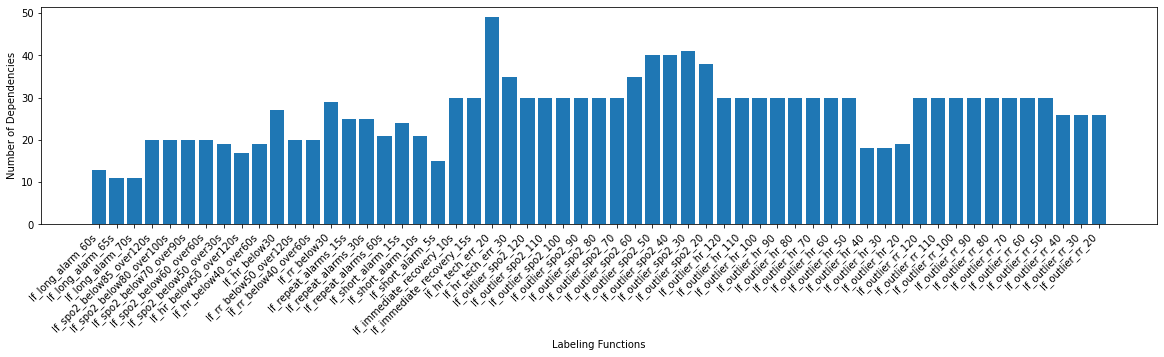

In [13]:
plt.figure(figsize=(20,4))
plt.bar(nodes_sorted[:,0], nodes_sorted[:,1])
plt.xticks(range(len(lfs)), lf_names, rotation=45, ha="right")
plt.xlabel("Labeling Functions")
plt.ylabel("Number of Dependencies")
plt.show()

#### Draw Dependency Graph

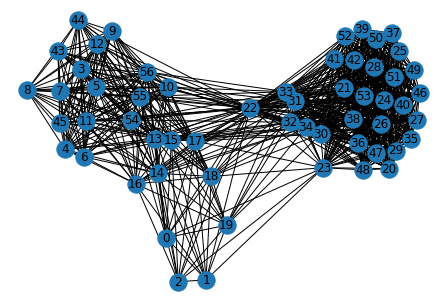

In [14]:
import networkx as nx

# define which dependencies to graph
deps = our_deps

G = nx.Graph()
G.add_edges_from(deps)
nx.draw(G, with_labels=True, font_size=12)

## Run Experiments

In [15]:
# Run other experiments in other notebooks
#%run ./experiments/e1-deppvalue.ipynb
#%run ./experiments/e2-maxindepsetlfs.ipynb
#%run ./experiments/e3-mostdependencies.ipynb

### Experiments for Reducing Dependencies

In [16]:
def make_lf(mis, l_model):
    @labeling_function(name="lf_mis" + str(mis))
    def lf_mis(x):
        return l_model.predict( np.asarray( [x[mis]] ) )[0]

    return lf_mis

In [17]:
from Our_Monitors.CD_Monitor_v1 import CDM
from snorkel.labeling import LFApplier
import igraph as ig
import random

seed = 42
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

for i, (train_dev_idx, test_idx) in enumerate(kf.split(L_alarms)):
    if i!=2:
        continue

    train_idx, dev_idx = train_test_split(train_dev_idx, test_size=0.25, random_state=seed)

    # Define training dataset
    L_train_all = L_alarms[train_idx]
    Y_train = alarms_df.true_label.values[train_idx]
    # Define development dataset
    L_dev = L_alarms[dev_idx]
    Y_dev = alarms_df.true_label.values[dev_idx]
    # Define test dataset
    L_test = L_alarms[test_idx]
    Y_test = alarms_df.true_label.values[test_idx]

    # Get edges of dependency graph from Conditional Dependency Monitor (CDM)
    our_deps = CDM(L_dev, Y_dev, k=2, sig=0.05, verbose=False)

    # Generate graph from dependencies and compute maximum independent set
    G = ig.Graph()
    G.add_vertices(len(lfs))
    G.add_edges(our_deps)
    max_indep_sets = G.largest_independent_vertex_sets()
    print(len(max_indep_sets), len(max_indep_sets[0]))

    # Generate LF per maximum independent set
    max_indep_sets_subset = random.sample(max_indep_sets, 100)
    print(max_indep_sets_subset)
    mis_lfs = []
    for i, mis in enumerate(max_indep_sets_subset):
        mis = list(mis)
        l_model = LabelModel(cardinality=2, verbose=True)
        l_model.fit(L_train_all[:,mis], log_freq=10, seed=seed)
        mis_lfs.append( make_lf(mis, l_model) )

    # Determine dependencies between new LFs
    app = LFApplier(mis_lfs)
    L = app.apply(L_alarms, progress_bar=True)
    deps = CDM(L, alarms_df.true_label.values, k=2, sig=0.05, verbose=False)
    print(len(deps))

    #l_model = LabelModel(cardinality=2, verbose=True)
    #l_model.fit(L, lr=, log_freq=10, seed=seed)
    #print( l_model.score(L, alarms_df.true_label.values) )

    #break

4429 4
[(12, 15, 17, 29), (4, 14, 19, 22), (1, 16, 43, 51), (16, 18, 38, 44), (16, 17, 24, 45), (12, 16, 17, 28), (15, 19, 26, 44), (15, 19, 45, 48), (3, 14, 17, 37), (7, 14, 18, 24), (0, 15, 45, 49), (8, 16, 17, 29), (5, 14, 17, 49), (1, 16, 45, 47), (6, 14, 19, 22), (5, 15, 19, 37), (15, 19, 43, 52), (14, 17, 24, 43), (9, 14, 17, 47), (4, 16, 18, 31), (0, 8, 14, 51), (14, 17, 41, 45), (4, 14, 17, 42), (11, 14, 17, 34), (8, 15, 17, 35), (16, 18, 37, 44), (12, 16, 17, 35), (4, 16, 19, 36), (0, 15, 42, 45), (0, 14, 45, 53), (2, 14, 38, 43), (1, 15, 43, 47), (16, 19, 37, 45), (2, 13, 16, 30), (1, 8, 16, 40), (16, 18, 27, 44), (11, 16, 17, 24), (15, 17, 35, 44), (12, 16, 19, 27), (6, 14, 19, 39), (8, 16, 18, 25), (1, 16, 24, 44), (2, 16, 39, 43), (11, 15, 17, 23), (2, 16, 20, 43), (4, 16, 17, 36), (11, 14, 19, 28), (0, 16, 41, 45), (8, 15, 19, 36), (11, 14, 17, 23), (15, 17, 37, 44), (12, 16, 17, 47), (16, 19, 25, 45), (0, 16, 33, 45), (0, 14, 20, 44), (7, 15, 17, 40), (3, 16, 19, 30), (1

IndexError: index 0 is out of bounds for axis 0 with size 0